In [1]:
import gym
import gym.utils.env_checker
import numpy as np

import flowgym
import flowgym.utils

import tf_agents.environments.gym_wrapper
import tensorflow as tf
from tf_agents.networks import q_network
from tf_agents.agents.dqn import dqn_agent
import tf_agents.replay_buffers
import tf_agents.drivers

import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2722302119494023715
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14286848000
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1152549752490144774
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [3]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)
#device_count = {'GPU': 1}
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [4]:
env = gym.make('flowgym/FlowWorldEnv-v0', normalize=False)
learning_rate = 0.001

In [5]:
obs = env.reset()

In [6]:
XY = np.mgrid[:256, :256]
X, Y = XY

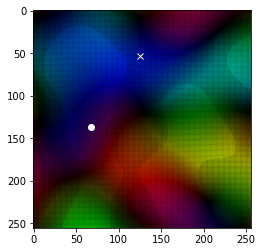

In [7]:
env.render()


# Wrap OpenAI Gym environment in Tensorflow Agent Environment
The gym environment provides a python/numpy environment. Tensorflow has slightly different names for variables (space is called spec). It also wants to wrap numpy arrays as tensors, so that they can be moved to the GPU for training. 

In [8]:
py_env = tf_agents.environments.gym_wrapper.GymWrapper(gym_env=env)
tf_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(py_env)


# Create the Neural Network
We will use a QNetwork, a simple 1D perceptron layer as a training network. We could make this smarter, but for now this is sufficient. We need to combine our three imputs (velocity, target, agent) to a 1d vector. We will just  flatten and concatenate all our numbers into a (255x255x2 + 2 + 2) vector for this. 

In [9]:
preprocessing_layers = {
    'target': tf.keras.layers.Flatten(),
    'agent': tf.keras.layers.Flatten(),
    'velocity': tf.keras.layers.Flatten()
}

preprocessing_combiner = tf.keras.layers.Concatenate()

q_net = q_network.QNetwork(
  tf_env.observation_spec(),
  tf_env.action_spec(),
  fc_layer_params=(100,),
  preprocessing_layers=preprocessing_layers,
  preprocessing_combiner=preprocessing_combiner
)


# Optimizer
We need to define an algorithm that will optimize. An Adam optimizer is quite common. The learning rate is a hyper parameter, specified on top of the notebook. 

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
td_errors_loss = tf_agents.utils.common.element_wise_squared_loss
# tf_agents.utils.common.aggregate_losses

# Make the Agent
Now that we have our environment, network and optimizer defined, we can now create an agent. 

In [11]:
with tf.device('/CPU:0'):
  agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=td_errors_loss,
    train_step_counter=tf.Variable(0))

  agent.initialize()

# Policy
An agent can be trained. But it needs a policy to pick the best move based on the trained parameters. 
Let's start with a random policy. 

In [12]:
random_policy = tf_agents.policies.random_tf_policy.RandomTFPolicy(
    tf_env.time_step_spec(),
    tf_env.action_spec()
)
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [13]:
# Let's pick an action, given the current environment.
# This policy will not use the agent but pick a random action. 
time_step = tf_env.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([7], dtype=int64)>, state=(), info=())

# Replay buffer
Before we can train our agent we also need to define the data collection. Based on the collect_data_spec we can setup a replay buffer. Based on the buffer we can setup a replay observer. 

In [14]:
replay_buffer_capacity = 1000

replay_buffer = tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity
)

replay_observer = [replay_buffer.add_batch]

# Driver
Now we can use the replay_observer to define a data collection driver. 

In [15]:
collect_steps_per_iteration = 10
collect_op = tf_agents.drivers.dynamic_step_driver.DynamicStepDriver(
  tf_env,
  agent.collect_policy,
  observers=replay_observer,
  num_steps=collect_steps_per_iteration
).run()

InternalError: Exception encountered when calling layer "dense" (type Dense).

Attempting to perform BLAS operation using StreamExecutor without BLAS support [Op:MatMul]

Call arguments received by layer "dense" (type Dense):
  • inputs=tf.Tensor(shape=(1, 131076), dtype=float32)

# Dataset
Now we can create a dataset from the buffer. We can pass the iterator over the dataset to store our experience.

In [16]:
dataset = replay_buffer.as_dataset(
    sample_batch_size=tf_env.batch_size,
    num_steps=2
)

iterator = iter(dataset)



Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


In [17]:
tf_env.batch_size

1

# Let's start training.

In [19]:
with tf.device('/CPU:0'):
    num_train_steps = 20
    losses = []
    for _ in tqdm.tqdm(range(num_train_steps), desc='gather data'):
        time_step = tf_env.reset()
        for i in range(collect_steps_per_iteration):
            time_step = tf_env.current_time_step()
            # action_step = random_policy.action(time_step)
            action_step = agent.policy.action(time_step)
            next_time_step = tf_env.step(action_step.action)
            traj = tf_agents.trajectories.trajectory.from_transition(time_step, action_step, next_time_step)

            # Add trajectory to the replay buffer
            replay_buffer.add_batch(traj)    

        experience, _ = next(iterator)
        loss = agent.train(experience=experience)
        losses.append(loss)
        if i > 400:
            break
        

gather data:   0%|          | 0/20 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


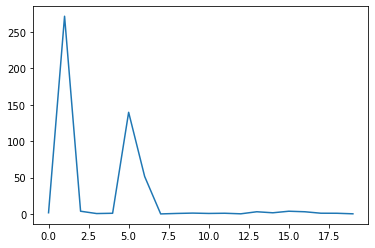

In [20]:
import pandas as pd
df = pd.DataFrame(losses)
df['loss'] = df.loss.apply(lambda x: x.numpy())
plt.plot(df['loss'])


In [22]:
with tf.device('/CPU:0'):
    actions = []
    step = tf_env.reset()
    steps = [step]
    positions = []
    for i in range(100):
        action = agent.policy.action(step)
        step = tf_env.step(action)        
        actions.append(action)
        steps.append(step)